In [1]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
series = read_csv('water.csv', header=0, parse_dates=True)

In [3]:
series

,Year,Water
0,1885,356
1,1886,386
2,1887,397
3,1888,397
4,1889,413
...,...,...
74,1959,594
75,1960,587
76,1961,587
77,1962,625


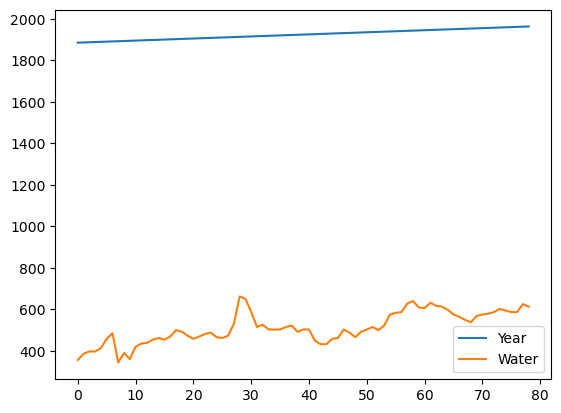

In [4]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
series.plot()
pyplot.show()

array([[<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Water'}>]], dtype=object)

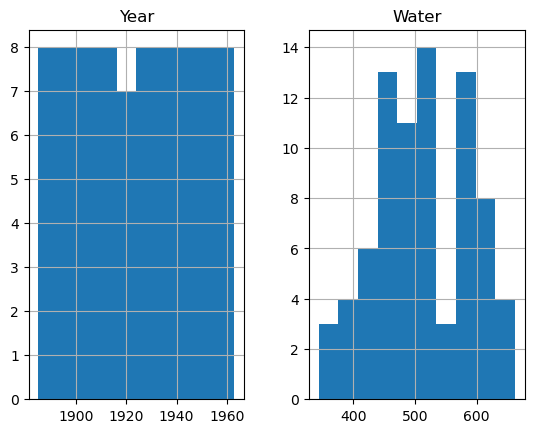

In [5]:
series.hist()

<AxesSubplot:ylabel='Density'>

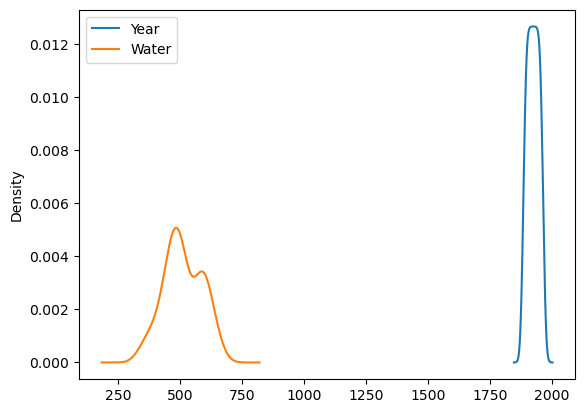

In [6]:
series.plot(kind='kde')

In [7]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 69, Validation 10


#### Persistence/ Base model

In [8]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2592\1853448735.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)


In [9]:
train

array([[1885.,  356.],
       [1886.,  386.],
       [1887.,  397.],
       [1888.,  397.],
       [1889.,  413.],
       [1890.,  458.],
       [1891.,  485.],
       [1892.,  344.],
       [1893.,  390.],
       [1894.,  360.],
       [1895.,  420.],
       [1896.,  435.],
       [1897.,  439.],
       [1898.,  454.],
       [1899.,  462.],
       [1900.,  454.],
       [1901.,  469.],
       [1902.,  500.],
       [1903.,  492.],
       [1904.,  473.],
       [1905.,  458.],
       [1906.,  469.],
       [1907.,  481.],
       [1908.,  488.],
       [1909.,  466.],
       [1910.,  462.],
       [1911.,  473.],
       [1912.,  530.],
       [1913.,  662.],
       [1914.,  651.],
       [1915.,  587.],
       [1916.,  515.],
       [1917.,  526.],
       [1918.,  503.]], dtype=float32)

In [10]:
test

array([[1919.,  503.],
       [1920.,  503.],
       [1921.,  515.],
       [1922.,  522.],
       [1923.,  492.],
       [1924.,  503.],
       [1925.,  503.],
       [1926.,  450.],
       [1927.,  432.],
       [1928.,  432.],
       [1929.,  458.],
       [1930.,  462.],
       [1931.,  503.],
       [1932.,  488.],
       [1933.,  466.],
       [1934.,  492.],
       [1935.,  503.],
       [1936.,  515.],
       [1937.,  500.],
       [1938.,  522.],
       [1939.,  575.],
       [1940.,  583.],
       [1941.,  587.],
       [1942.,  628.],
       [1943.,  640.],
       [1944.,  609.],
       [1945.,  606.],
       [1946.,  632.],
       [1947.,  617.],
       [1948.,  613.],
       [1949.,  598.],
       [1950.,  575.],
       [1951.,  564.],
       [1952.,  549.],
       [1953.,  538.]], dtype=float32)

In [11]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

TypeError: only size-1 arrays can be converted to Python scalars

#### ARIMA Hyperparameters

In [12]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [13]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [14]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
#p_values = range(0, 5)
#d_values = range(0, 5)
#q_values = range(0, 5)
warnings.filterwarnings("ignore")
#evaluate_models(train.values, p_values, d_values, q_values)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2592\380348267.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)


#### Build Model based on the optimized values

In [15]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
import numpy

In [16]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [17]:
# fit model
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.predict(1, 79)

ValueError: SARIMAX models require univariate `endog`. Got shape (68, 2).

In [18]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
val

,0,1,2
0,69,1954,568
1,70,1955,575
2,71,1956,579
3,72,1957,587
4,73,1958,602
5,74,1959,594
6,75,1960,587
7,76,1961,587
8,77,1962,625
9,78,1963,613


In [19]:
val[1]

0    1954
1    1955
2    1956
3    1957
4    1958
5    1959
6    1960
7    1961
8    1962
9    1963
Name: 1, dtype: int64

In [20]:
series['Water'][69:]

69    568
70    575
71    579
72    587
73    602
74    594
75    587
76    587
77    625
78    613
Name: Water, dtype: int64

In [21]:
rmse = sqrt(mean_squared_error(val[1],series['Water'][69:]))
rmse

1366.8745370369586

#### Combine train and test data and build final model

In [22]:
# fit model
data = read_csv('water.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [23]:
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()

ValueError: SARIMAX models require univariate `endog`. Got shape (68, 2).

In [24]:
forecast

NameError: name 'forecast' is not defined

In [25]:
forecast=model_fit.forecast(steps=10)

NameError: name 'model_fit' is not defined

In [26]:
forecast

NameError: name 'forecast' is not defined

In [ ]:
series['Water'][69:]